# Example 2a: Double Well - Training of DeepCalib

Example code to train DeepCalib to determine the parameters of a double trap.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a double well trap, and the motion of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

This file is used to reproduce results that are shown in Fig.3 and generate the pretrained network "Network_Example_2a.h5" that is going to be needed to execute Example 2b.

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
### Physical parameters 
from math import pi
import numpy as np
from scipy.constants import Boltzmann as kB
R = 1e-7                              # Radius of the Brownian particle [m]
eta = 0.001                           # Viscosity of the medium [kg m^-1 s^-1]
T = 300                               # Temperature [K]
L0 = 2e-6                             # Reference distance from middle to one minimum [m]
H0 = kB*300                           # Barrier height [Joule]
gamma0 =  3 * 6 * pi * eta * R         # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 5e-2                  # Timestep 
dt = 2e-3
oversampling = int(Dt/dt)  # Simulation oversampling
offset = 1000              # Number of equilibration points

### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units



### Define function to scale and rescale targets
from numpy import log10

scale_targets = lambda L, H: [L/L0 -1, 
                              np.log(H / H0)]                        # Scales targets to order 1
rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0*1e6, 
                                              np.exp(scaled_H) * H0/kB/300] # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32, 
                        T=T,
                        L0=L0,
                        H0=H0,
                        gamma0=gamma0,
                        N=N, 
                        dt=dt, 
                        oversampling=oversampling, 
                        offset=offset,
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a double trap
    
    Inputs:
    
    T:              temperature of the environment
    L0:             center of the equilibrium distance range
    H0:             center of the barrier height range
    gamma0:         friction coefficient
    N:              number of trajectory data points
    Dt:             measurement period
    oversampling:   oversampling from the simulation time step (to calculate dt)
    offset:         steps of the simulation before starting to save the trajectory
    scale_inputs:   inputs scale function for the network, to normalize it comparable to 1 
    scale_targets:  targets scale function for the network, to normalize it comparable to 1
        
    Outputs:
    
    inputs: the inputs for the network, these are trajectories that have the following features: 
            
            inputs.names:          names of the input trajectory variables ('x', 'y' etc)
            inputs.values:         values of the inputs in SI units
            inputs.scalings:       short description of the scaling function for the inputs ('x*1e6' etc)
            inputs.scaled_values:  scaled values of the inputs to be passed to the network for training
            
    targets: the expected ground truth measurements for the trajectory that have following features: 
            
            targets.names:          names of the targets to be measures ('k' etc)
            targets.values:         values of the ground truth targets in SI units
            targets.scalings:       short description of the scaling function for the targets ('log(k/k0)' etc)
            targets.scaled_values:  scaled values of the ground truth targets to be passed to the network for training      
    """    

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    L = L0 * (uniform(batch_size)+.5) 
    H = H0 * 10**(uniform(batch_size)*1.75 - .75)  
    gamma = gamma0 * (uniform(batch_size)*.1 + .95)    
    
    ### Simulate
    x = np.zeros((batch_size, N))
    k0 = 4*H/L**2 
    k1 = 4*H/L**4
    D = kB * T / gamma
    C1 = +k0 / gamma * dt
    C2 = -k1 / gamma * dt
    C3 = np.sqrt(2 * D * dt)
    
    X = x[:,0]
    n = 0
    
    for t in range(offset):                      # Offset  
        
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        
    for t in range(N * oversampling):            # Simulation
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        if t % oversampling == 0:
            x[:,n] = X 
            n += 1
    
    # Normalize trajectory and targets
    inputs = DeepCalib.trajectory(
        names=['x'],
        values=x, 
        scalings=['x * 1e-6'], 
        scaled_values=scale_inputs(x))
    
    targets = DeepCalib.targets(
        names=['Distance [$\mu$m]', 'Barrier Height [$k_BT$]'], 
        values=np.swapaxes([L*1e6, H/kB/300],0,1), 
        scalings=['L/L0 -1', 'log(H/H0)'], 
        scaled_values=np.swapaxes(scale_targets(*[L, H]),0,1))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

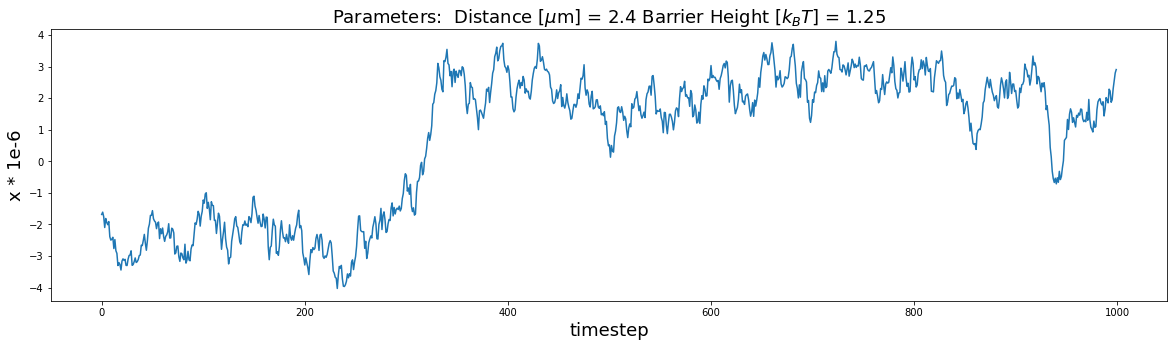

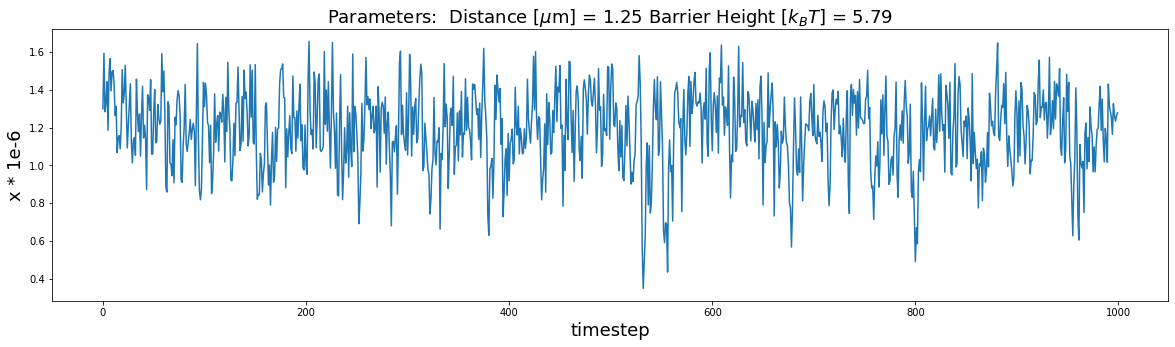

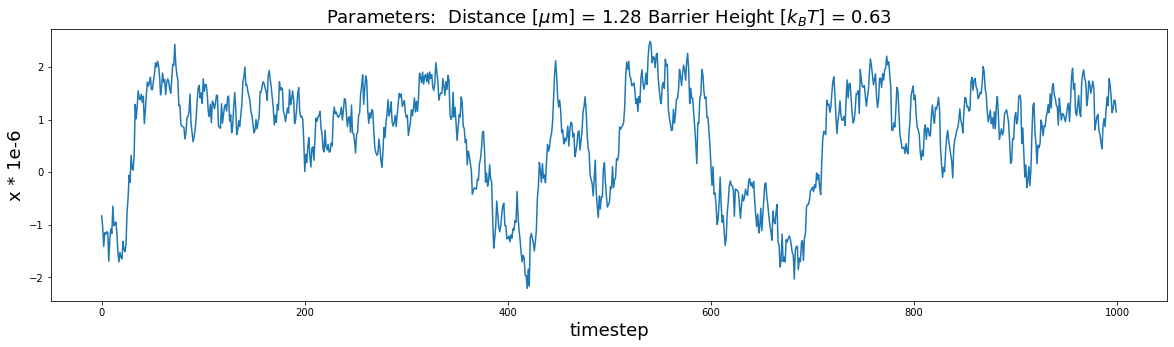

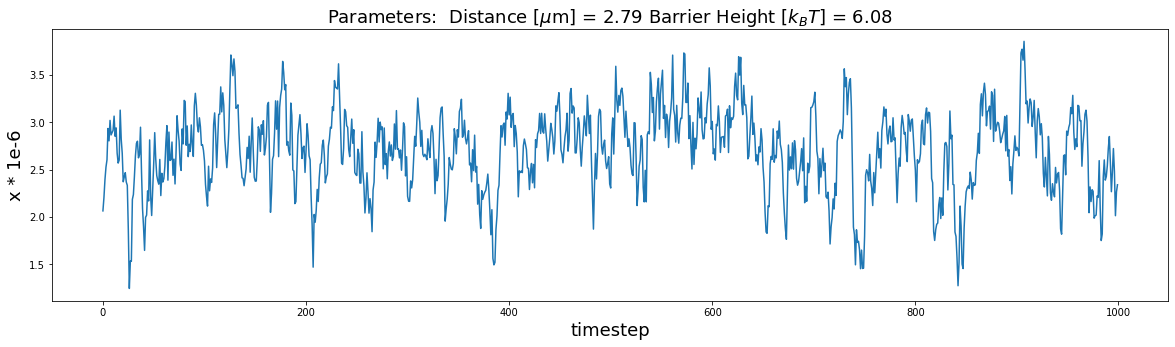

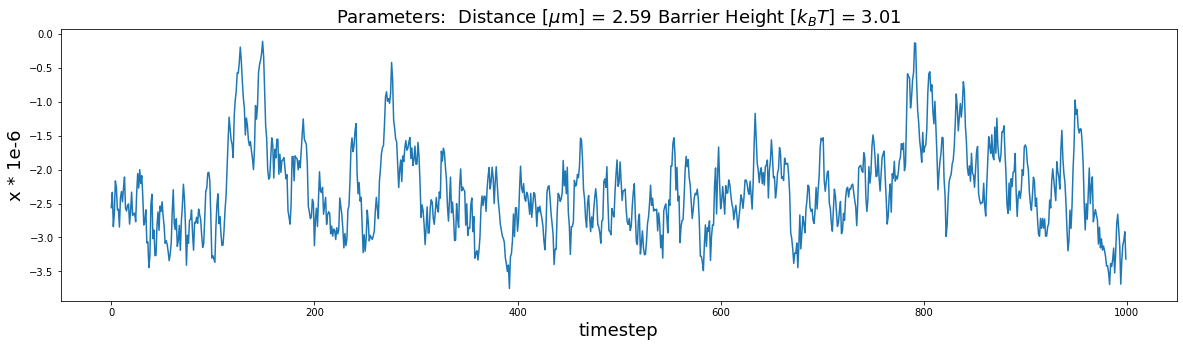

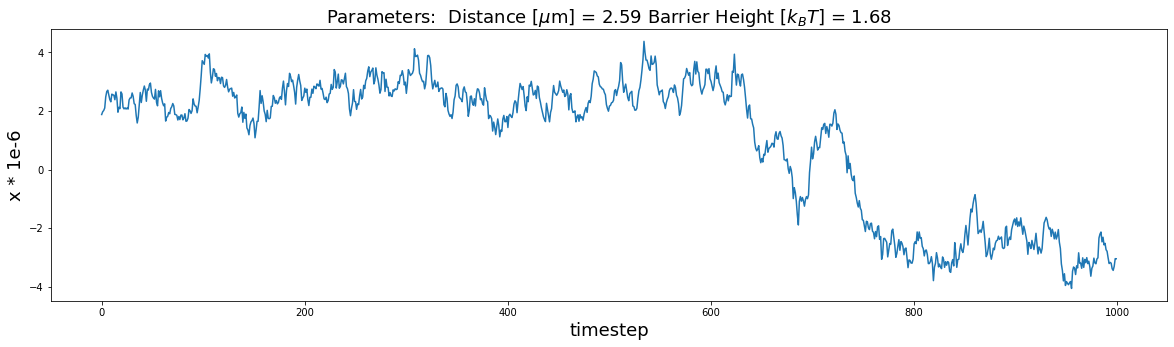

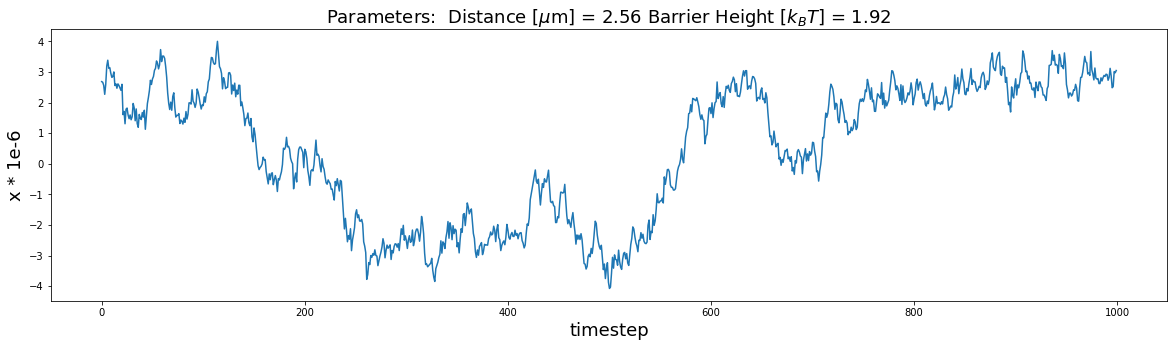

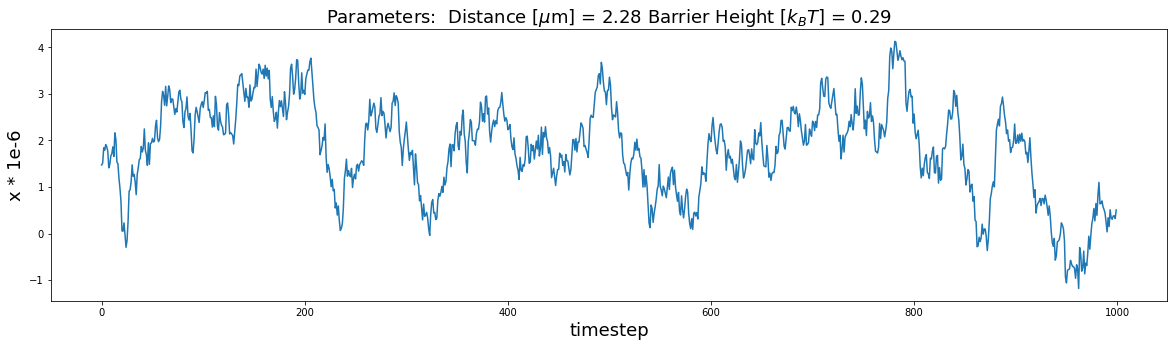

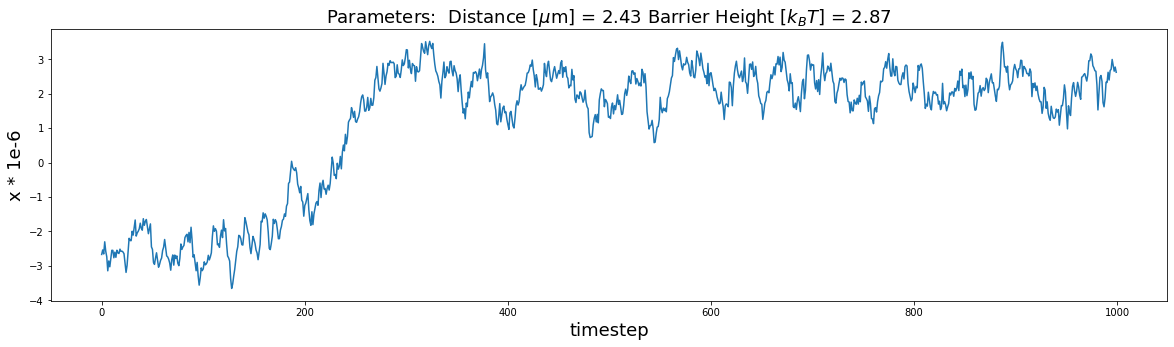

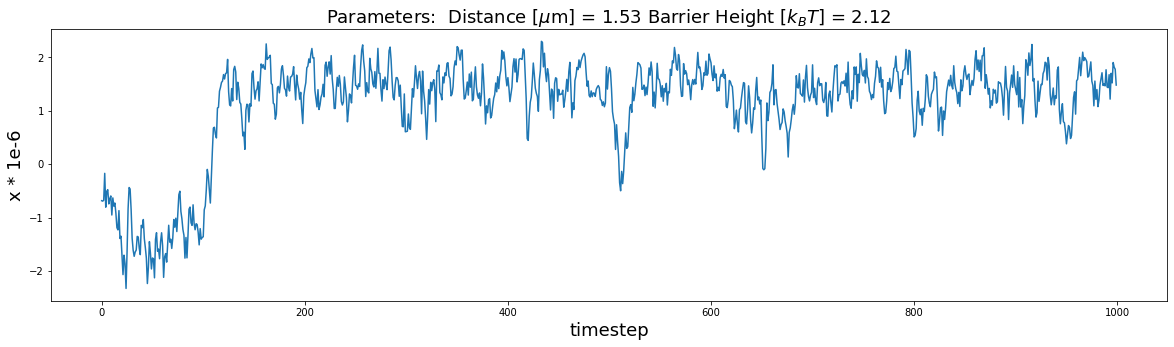

In [3]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10

%matplotlib inline
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [6]:
### Define parameters of the deep learning network
input_shape = (20, 50)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 2

### Create deep learning network
network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 1000)          4204000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 250)           1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 2)                 102       
Total params: 5,515,302
Trainable params: 5,515,302
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [7]:
## Define parameters of the training
sample_sizes = (32, 128, 512, 2048)
iteration_numbers = (1001, 1001, 2001, 4001)

verbose = .1

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     0.8478   MAE     0.6539   Time 5084.290266 ms
Sample size     32   iteration number     11   MSE     0.8566   MAE     0.6822   Time 267.284870 ms
Sample size     32   iteration number     21   MSE     0.5012   MAE     0.5232   Time 262.298822 ms
Sample size     32   iteration number     31   MSE     0.4282   MAE     0.4533   Time 262.298822 ms
Sample size     32   iteration number     41   MSE     0.5193   MAE     0.5206   Time 259.306908 ms
Sample size     32   iteration number     51   MSE     0.5139   MAE     0.5090   Time 271.273375 ms
Sample size     32   iteration number     61   MSE     0.3357   MAE     0.3905   Time 266.233444 ms
Sample size     32   iteration number     71   MSE     0.3570   MAE     0.4207   Time 264.293671 ms
Sample size     32   iteration number     81   MSE     0.4015   MAE     0.4356   Time 263.295889 ms
Sample size     32   iteration number     91   MSE     0.3715   MAE     0.4166   Time 266.288280 ms

Sample size     32   iteration number    821   MSE     0.1542   MAE     0.2533   Time 268.282175 ms
Sample size     32   iteration number    831   MSE     0.1170   MAE     0.2406   Time 266.288280 ms
Sample size     32   iteration number    841   MSE     0.1056   MAE     0.2015   Time 264.325619 ms
Sample size     32   iteration number    851   MSE     0.1302   MAE     0.2185   Time 263.295889 ms
Sample size     32   iteration number    861   MSE     0.1502   MAE     0.2664   Time 251.512051 ms
Sample size     32   iteration number    871   MSE     0.1981   MAE     0.3108   Time 271.306753 ms
Sample size     32   iteration number    881   MSE     0.1613   MAE     0.2483   Time 321.139574 ms
Sample size     32   iteration number    891   MSE     0.0867   MAE     0.2018   Time 262.297630 ms
Sample size     32   iteration number    901   MSE     0.1113   MAE     0.2078   Time 260.766506 ms
Sample size     32   iteration number    911   MSE     0.0930   MAE     0.1967   Time 319.144487 ms


Sample size    128   iteration number    631   MSE     0.0801   MAE     0.1705   Time 436.831713 ms
Sample size    128   iteration number    641   MSE     0.1272   MAE     0.2027   Time 436.831951 ms
Sample size    128   iteration number    651   MSE     0.1007   MAE     0.1941   Time 431.845188 ms
Sample size    128   iteration number    661   MSE     0.0960   MAE     0.1930   Time 436.832190 ms
Sample size    128   iteration number    671   MSE     0.0976   MAE     0.1875   Time 439.824581 ms
Sample size    128   iteration number    681   MSE     0.0990   MAE     0.1994   Time 435.803175 ms
Sample size    128   iteration number    691   MSE     0.0953   MAE     0.1869   Time 438.795328 ms
Sample size    128   iteration number    701   MSE     0.0828   MAE     0.1727   Time 439.216375 ms
Sample size    128   iteration number    711   MSE     0.0922   MAE     0.1900   Time 437.828302 ms
Sample size    128   iteration number    721   MSE     0.0911   MAE     0.1784   Time 441.786051 ms


Sample size    512   iteration number    441   MSE     0.0814   MAE     0.1758   Time 1140.917063 ms
Sample size    512   iteration number    451   MSE     0.0786   MAE     0.1739   Time 1140.943766 ms
Sample size    512   iteration number    461   MSE     0.0765   MAE     0.1684   Time 1153.928280 ms
Sample size    512   iteration number    471   MSE     0.0798   MAE     0.1744   Time 1149.926186 ms
Sample size    512   iteration number    481   MSE     0.0748   MAE     0.1701   Time 1158.876657 ms
Sample size    512   iteration number    491   MSE     0.0675   MAE     0.1518   Time 1166.879892 ms
Sample size    512   iteration number    501   MSE     0.0781   MAE     0.1650   Time 1141.947269 ms
Sample size    512   iteration number    511   MSE     0.0721   MAE     0.1633   Time 1150.438309 ms
Sample size    512   iteration number    521   MSE     0.0754   MAE     0.1661   Time 1148.959398 ms
Sample size    512   iteration number    531   MSE     0.0741   MAE     0.1645   Time 1157.

Sample size    512   iteration number   1261   MSE     0.0775   MAE     0.1689   Time 1140.002728 ms
Sample size    512   iteration number   1271   MSE     0.0813   MAE     0.1699   Time 1141.945839 ms
Sample size    512   iteration number   1281   MSE     0.0798   MAE     0.1720   Time 1143.907547 ms
Sample size    512   iteration number   1291   MSE     0.0723   MAE     0.1659   Time 1137.960672 ms
Sample size    512   iteration number   1301   MSE     0.0857   MAE     0.1819   Time 1149.950504 ms
Sample size    512   iteration number   1311   MSE     0.0719   MAE     0.1676   Time 1159.896612 ms
Sample size    512   iteration number   1321   MSE     0.0766   MAE     0.1674   Time 1159.898996 ms
Sample size    512   iteration number   1331   MSE     0.0835   MAE     0.1736   Time 1150.922060 ms
Sample size    512   iteration number   1341   MSE     0.0788   MAE     0.1729   Time 1157.937288 ms
Sample size    512   iteration number   1351   MSE     0.0774   MAE     0.1694   Time 1142.

Sample size   2048   iteration number     71   MSE     0.0697   MAE     0.1593   Time 3877.631664 ms
Sample size   2048   iteration number     81   MSE     0.0706   MAE     0.1600   Time 3897.550106 ms
Sample size   2048   iteration number     91   MSE     0.0744   MAE     0.1659   Time 3888.628960 ms
Sample size   2048   iteration number    101   MSE     0.0726   MAE     0.1579   Time 3876.634598 ms
Sample size   2048   iteration number    111   MSE     0.0756   MAE     0.1653   Time 3880.629778 ms
Sample size   2048   iteration number    121   MSE     0.0702   MAE     0.1579   Time 3926.526546 ms
Sample size   2048   iteration number    131   MSE     0.0763   MAE     0.1646   Time 3876.634359 ms
Sample size   2048   iteration number    141   MSE     0.0723   MAE     0.1607   Time 3878.628254 ms
Sample size   2048   iteration number    151   MSE     0.0697   MAE     0.1562   Time 3878.279924 ms
Sample size   2048   iteration number    161   MSE     0.0712   MAE     0.1588   Time 3882.

Sample size   2048   iteration number    891   MSE     0.0693   MAE     0.1590   Time 3937.466860 ms
Sample size   2048   iteration number    901   MSE     0.0664   MAE     0.1552   Time 3959.491014 ms
Sample size   2048   iteration number    911   MSE     0.0718   MAE     0.1579   Time 3943.456173 ms
Sample size   2048   iteration number    921   MSE     0.0679   MAE     0.1557   Time 3891.566753 ms
Sample size   2048   iteration number    931   MSE     0.0698   MAE     0.1585   Time 3887.604237 ms
Sample size   2048   iteration number    941   MSE     0.0691   MAE     0.1556   Time 3888.602257 ms
Sample size   2048   iteration number    951   MSE     0.0621   MAE     0.1492   Time 3884.612799 ms
Sample size   2048   iteration number    961   MSE     0.0723   MAE     0.1608   Time 3963.531256 ms
Sample size   2048   iteration number    971   MSE     0.0729   MAE     0.1620   Time 3945.482969 ms
Sample size   2048   iteration number    981   MSE     0.0714   MAE     0.1572   Time 3912.

Sample size   2048   iteration number   1711   MSE     0.0716   MAE     0.1587   Time 3919.518709 ms
Sample size   2048   iteration number   1721   MSE     0.0687   MAE     0.1533   Time 3883.616686 ms
Sample size   2048   iteration number   1731   MSE     0.0691   MAE     0.1588   Time 3889.599800 ms
Sample size   2048   iteration number   1741   MSE     0.0661   MAE     0.1553   Time 3937.471390 ms
Sample size   2048   iteration number   1751   MSE     0.0712   MAE     0.1594   Time 3899.598360 ms
Sample size   2048   iteration number   1761   MSE     0.0698   MAE     0.1577   Time 3888.602972 ms
Sample size   2048   iteration number   1771   MSE     0.0681   MAE     0.1524   Time 3883.643389 ms
Sample size   2048   iteration number   1781   MSE     0.0637   MAE     0.1509   Time 3878.749609 ms
Sample size   2048   iteration number   1791   MSE     0.0704   MAE     0.1573   Time 3880.598068 ms
Sample size   2048   iteration number   1801   MSE     0.0702   MAE     0.1558   Time 3910.

Sample size   2048   iteration number   2531   MSE     0.0646   MAE     0.1526   Time 4105.369806 ms
Sample size   2048   iteration number   2541   MSE     0.0734   MAE     0.1610   Time 4083.917141 ms
Sample size   2048   iteration number   2551   MSE     0.0686   MAE     0.1578   Time 4257.422447 ms
Sample size   2048   iteration number   2561   MSE     0.0731   MAE     0.1630   Time 4241.884708 ms
Sample size   2048   iteration number   2571   MSE     0.0655   MAE     0.1513   Time 4256.113768 ms
Sample size   2048   iteration number   2581   MSE     0.0685   MAE     0.1562   Time 3942.491531 ms
Sample size   2048   iteration number   2591   MSE     0.0692   MAE     0.1568   Time 3882.618189 ms
Sample size   2048   iteration number   2601   MSE     0.0696   MAE     0.1558   Time 3934.479952 ms
Sample size   2048   iteration number   2611   MSE     0.0670   MAE     0.1532   Time 3886.581898 ms
Sample size   2048   iteration number   2621   MSE     0.0694   MAE     0.1579   Time 3956.

Sample size   2048   iteration number   3351   MSE     0.0726   MAE     0.1585   Time 3874.333620 ms
Sample size   2048   iteration number   3361   MSE     0.0687   MAE     0.1577   Time 3865.965605 ms
Sample size   2048   iteration number   3371   MSE     0.0668   MAE     0.1535   Time 3910.335541 ms
Sample size   2048   iteration number   3381   MSE     0.0669   MAE     0.1547   Time 3877.591372 ms
Sample size   2048   iteration number   3391   MSE     0.0674   MAE     0.1544   Time 3903.387785 ms
Sample size   2048   iteration number   3401   MSE     0.0718   MAE     0.1604   Time 3880.841970 ms
Sample size   2048   iteration number   3411   MSE     0.0669   MAE     0.1510   Time 3874.020576 ms
Sample size   2048   iteration number   3421   MSE     0.0693   MAE     0.1564   Time 3870.798588 ms
Sample size   2048   iteration number   3431   MSE     0.0670   MAE     0.1522   Time 3928.923130 ms
Sample size   2048   iteration number   3441   MSE     0.0689   MAE     0.1548   Time 3874.

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

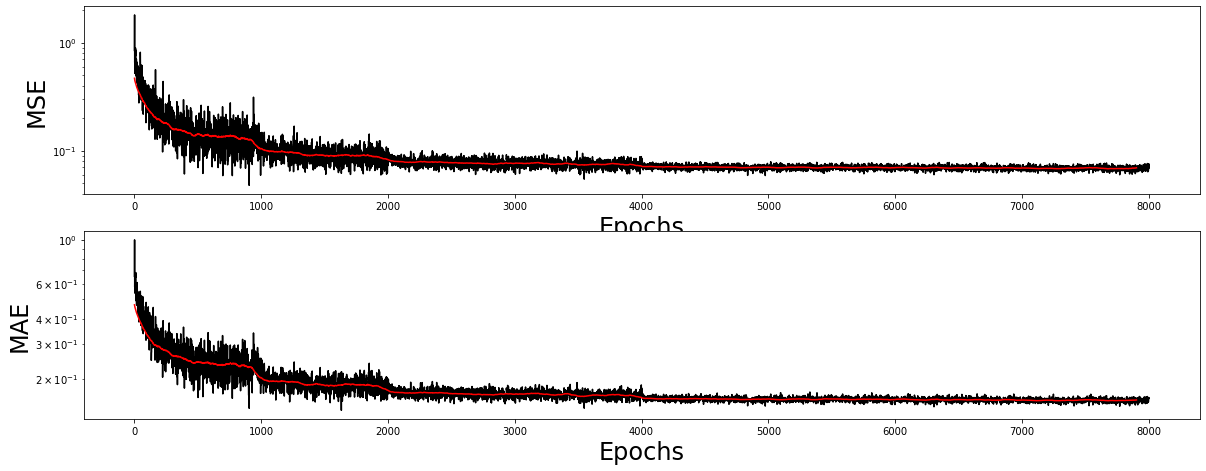

In [8]:
### Plot learning performance
number_of_timesteps_for_average = 100

DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

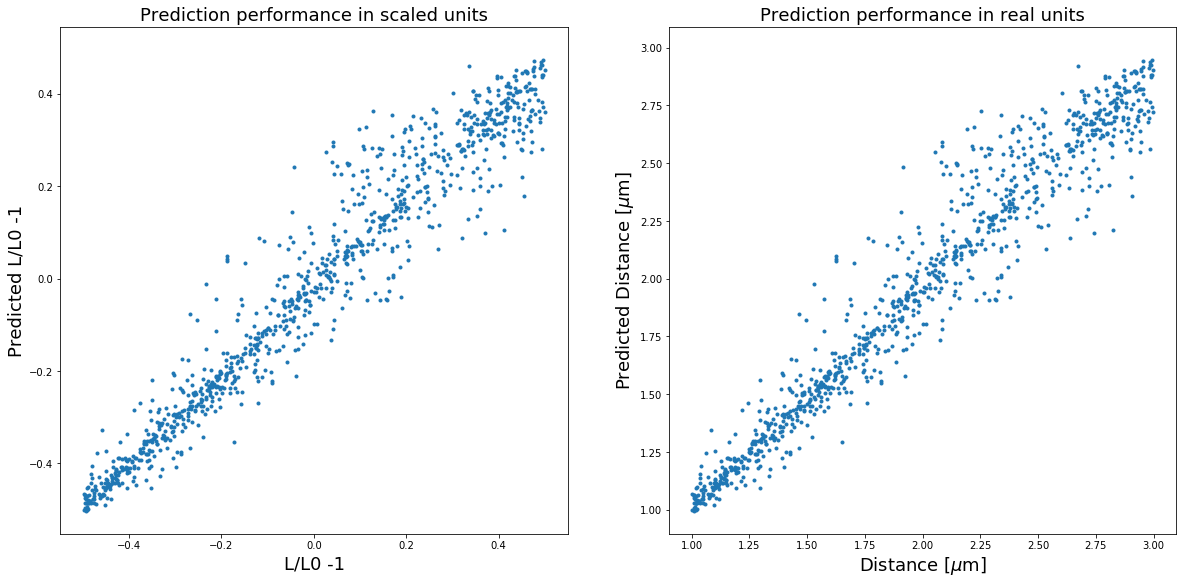

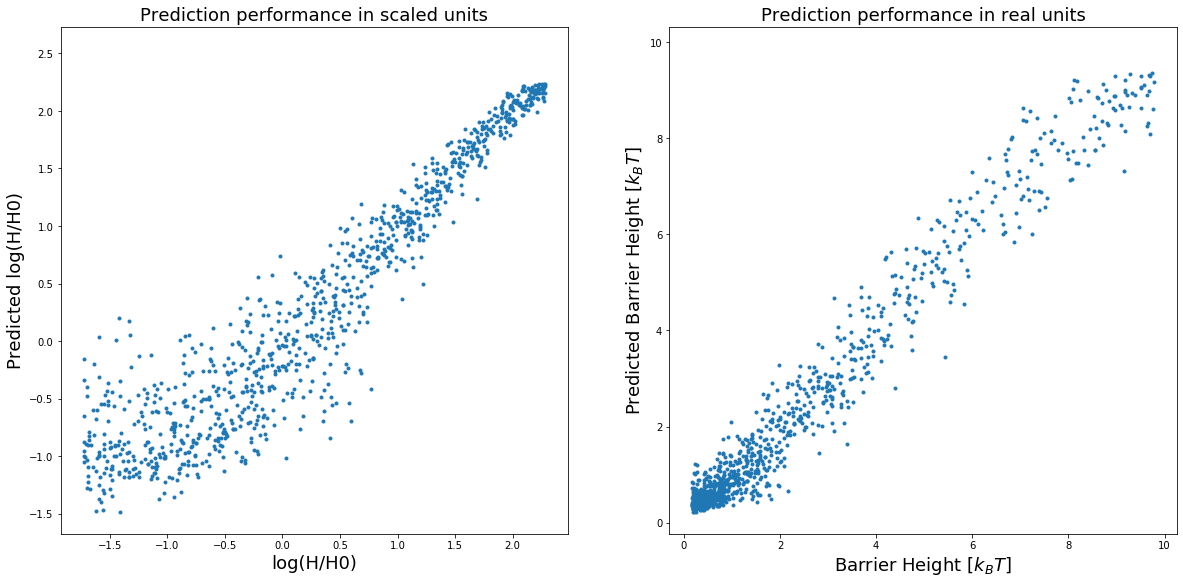

In [9]:
### Test the predictions of the deep learning network on some generated trajectories
number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 9. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [10]:
save_file_name = 'Network_Example_2a.h5'
network.save(save_file_name)